# Online Retail  -  Data Preprocessing

We will apply some Data Mining techniques to transform the data in a useful and efficient format to do our customer analysis.

In [1]:
# import libraries

# common libraries
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns 
import plotly
plotly.offline.init_notebook_mode (connected = True)
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import warnings
# current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import calendar
import datetime
import gc

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox

from sklearn import preprocessing

# this is needed for show figure in the notebook
%matplotlib inline
color = sns.color_palette()

In [2]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 100)

In [3]:
# Loading the data already cleaned before the EDA
# specify encoding to deal with different formats
df = pd.read_csv('../dataset/Online_Retail_II/data_cleaned.csv', encoding = 'ISO-8859-1')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    779495 non-null  int64  
 1   StockCode    779495 non-null  object 
 2   Year_month   779495 non-null  int64  
 3   Month        779495 non-null  int64  
 4   Day          779495 non-null  int64  
 5   Hour         779495 non-null  int64  
 6   Description  779495 non-null  object 
 7   Quantity     779495 non-null  int64  
 8   InvoiceDate  779495 non-null  object 
 9   UnitPrice    779495 non-null  float64
 10  CustomerID   779495 non-null  int64  
 11  Country      779495 non-null  object 
 12  TotalPrice   779495 non-null  float64
 13  ProductName  779495 non-null  object 
 14  dist         779495 non-null  float64
dtypes: float64(3), int64(7), object(5)
memory usage: 89.2+ MB


In [5]:
df.head()

,InvoiceNo,StockCode,Year_month,Month,Day,Hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,ProductName,dist
0,489434,85048,200912,12,2,7,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,15CM CHRISTMAS GLASS BALL 20 LIGHTS,1.0
1,489434,79323P,200912,12,2,7,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,PINK CHERRY LIGHTS,1.0
2,489434,79323W,200912,12,2,7,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,WHITE CHERRY LIGHTS,1.0
3,489434,22041,200912,12,2,7,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,"RECORD FRAME 7"" SINGLE SIZE",1.0
4,489434,21232,200912,12,2,7,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,STRAWBERRY CERAMIC TRINKET BOX,1.0


# Customer Segmentation

Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:

- **Higher Revenue**: This is the most obvious requirement of any customer segmentation project.
- **Customer Understanding**: One of the mostly widely accepted business paradigms is “know your customer” and a segmentation of the customer base allows for a perfect dissection of this paradigm.
- **Target Marketing**: The most visible reason for customer segmentation is the ability to focus marketing efforts effectively and efficiently. If a firm knows the different segments of its customer base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.
- **Optimal Product Placement**: A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.
- **Finding Latent Customer Segments**: Finding out which segment of customers it might be missing to identifying untapped customer segments by focused on marketing campaigns or new business development.


**Clustering:**

The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering. The method is as simple as collecting as much data about the customers as possible in the form of features or attributes and then finding out the different clusters that can be obtained from that data. Finally, we can find traits of customer segments by analyzing the characteristics of the clusters.


**RFM Model for Customer Value:**

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments.

The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

#### Recency

To create the recency feature variable, we need to decide the reference date for the analysis. Usually, the last transaction date plus one day is used. Then, the recency variable is constructed as the number of days before the reference date when a customer last made a purchase.

In [6]:
#refrence_date = df.InvoiceDate.max() + datetime.timedelta(days = 1)
refrence_date = datetime.datetime.strptime(df.InvoiceDate.max(), '%Y-%m-%d %H:%M:%S') + datetime.timedelta(days = 1)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
print('Reference Date:', refrence_date)
df['days_since_last_purchase'] = (refrence_date - df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
CustomerID,5881.0,15314.674205,1715.429759,12346.0,13833.0,15313.0,16797.0,18287.0
recency,5881.0,201.457745,209.474135,1.0,26.0,96.0,380.0,739.0


We will plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

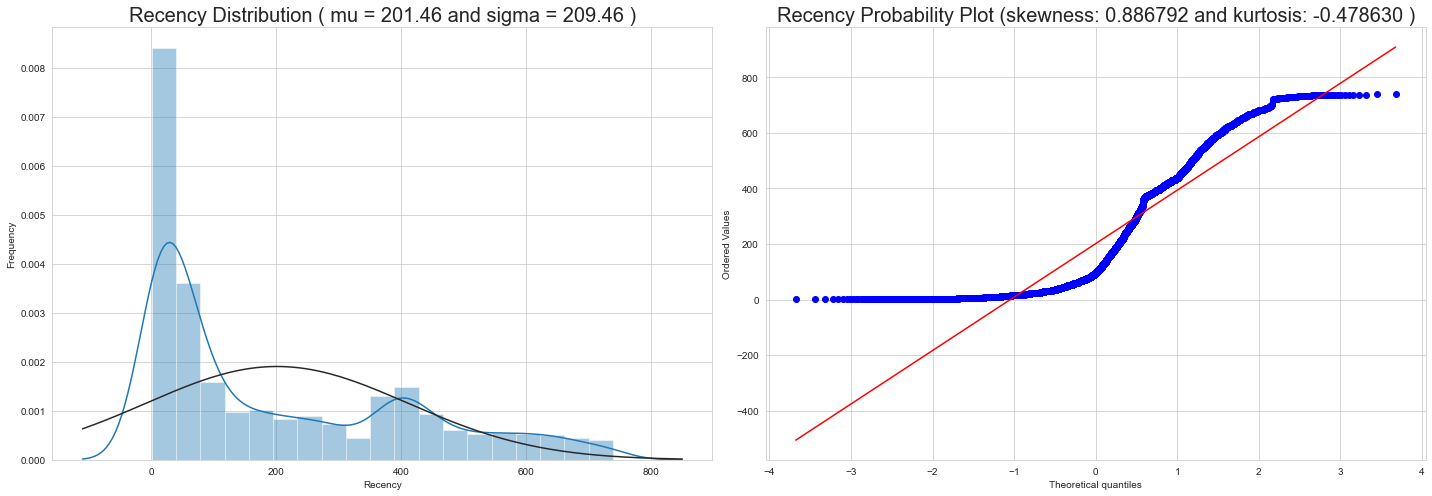

In [7]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center', fontsize=20)
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center', fontsize=20)

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

From the first graph above we can see that sales recency distribution is ***skewed***, has a **peak** on the left and a long tail to the right. It **deviates from normal distribution** and is **positively biased**.

From the **Probability Plot**, we could see that **sales recency** also does **not align with the diagonal  <span style="color:red">red line</span>** which represent normal distribution. The form of its distribution confirm that is a skewed right. 

With ***skewness positive of 1.25***, we confirm the **lack of symmetry** and indicate that sales recency  are **skewed right**, as we can see too at the Sales Distribution plot, skewed right means that the right tail is **long relative to the left tail**. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

**Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and **positive** kurtosis indicates a **heavy-tailed distribution** and **negative** kurtosis indicates a **light tailed distribution**. So, with 0.43 of positive kurtosis **sales recency** are heavy-tailed and has some **outliers**.

#### Frequency

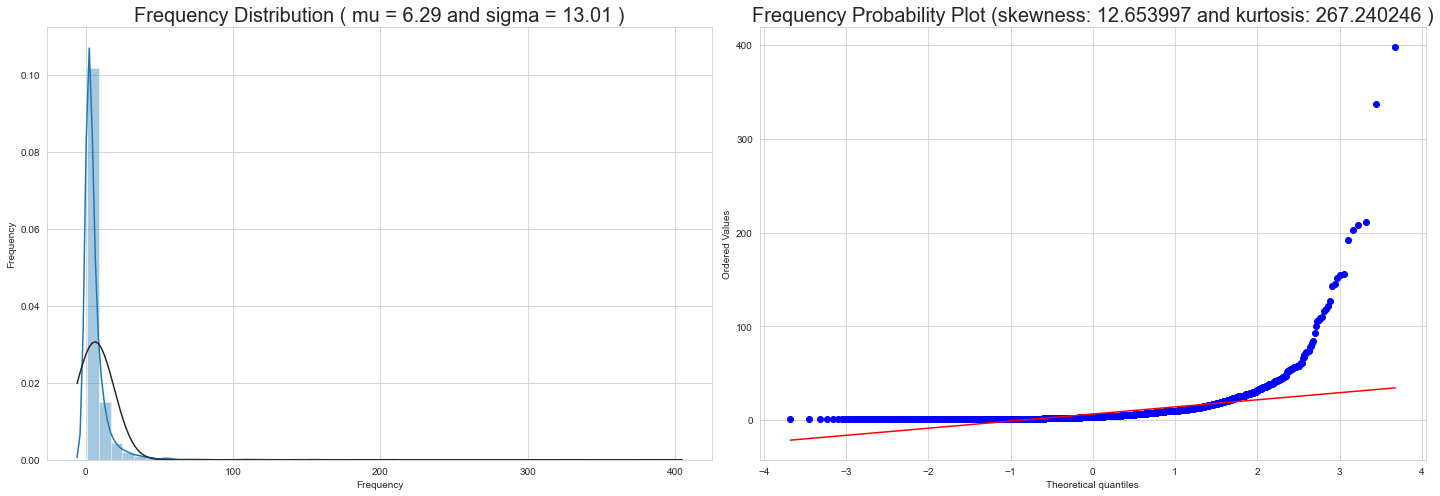

In [8]:
customer_freq = (df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

From the first graph above we can see that sales frequency distribution is ***skewed***, has a **peak** on the left and a long tail to the right. It **deviates from normal distribution** and is **positively biased**.

From the **Probability Plot**, we could see that **sales frequency** also does not align with the diagonal and confirm that is a skewed right. 

With ***skewness positive of 12.1***, we confirm the **high lack of symmetry** and with 249 **Kurtosis** indicates that is a **heavy-tailed distribution** and has **outliers**.

#### Monetary Value

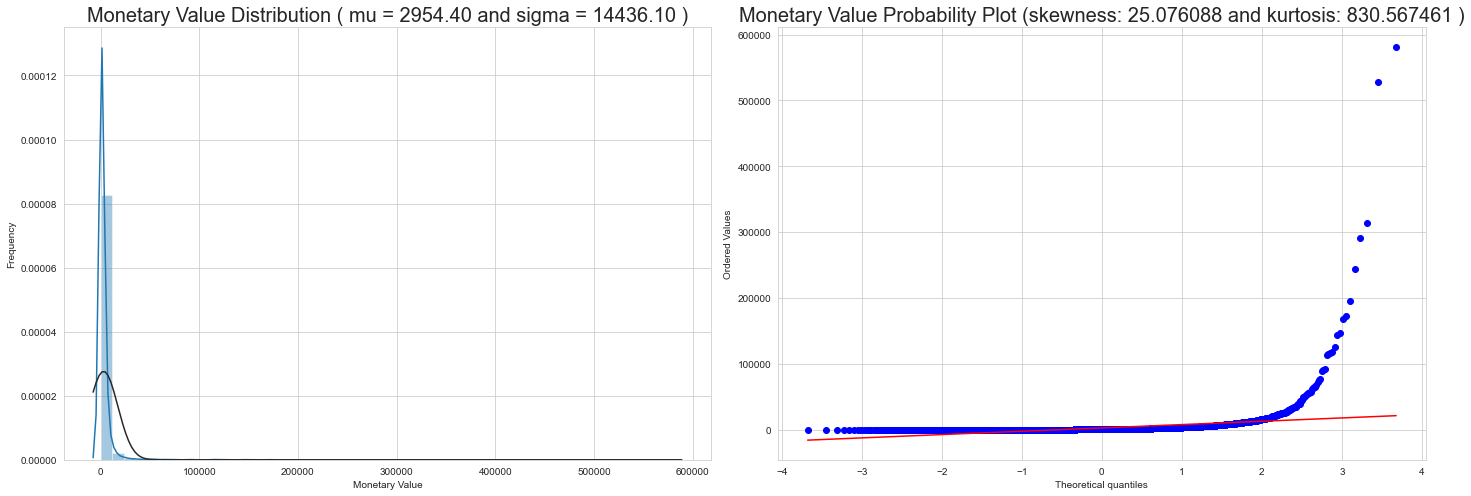

In [9]:
customer_monetary_val = df[['CustomerID', 'TotalPrice']].groupby("CustomerID").sum().reset_index()
customer_monetary_val.rename(columns={'TotalPrice':'monetary_value'},inplace=True)
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df['monetary_value'], 'Monetary Value')

From the first graph above we can see that sales amount distribution is ***skewed***, has a **peak** on the left and a long tail to the right. It **deviates from normal distribution** and is **positively biased**.

From the **Probability Plot**, we could see that **sales amount** also does **not align with the diagonal**, special on the right. 

With ***skewness positive of 19.3***, we confirm the **high lack of symmetry** and with 478 **Kurtosis** indicates that is a **too heavy-tailed distribution** and has **outliers**, surely more than 10 very extreme.

Let's see a statistical summary of this dataset:

In [10]:
customer_history_df.describe()

,CustomerID,recency,frequency,monetary_value
count,5881.000000,5881.000000,5881.000000,5881.000000
mean,15314.674205,201.457745,6.287196,2954.396237
std,1715.429759,209.474135,13.012879,14437.322635
min,12346.000000,1.000000,1.000000,0.000000
25%,13833.000000,26.000000,1.000000,341.900000
50%,15313.000000,96.000000,3.000000,865.600000
75%,16797.000000,380.000000,7.000000,2247.720000
max,18287.000000,739.000000,398.000000,580987.040000


In [11]:
# TODO rimuovere queste info
df.CustomerID.unique().size

5881

In [12]:
df.CustomerID.size

779495

Once we have created our customer value dataset, we will perform some preprocessing on the data. For our clustering, we will be using the K-means clustering algorithm. One of the requirements for proper functioning of the algorithm is the mean centering of the variable values. Mean centering of a variable value means that we will replace the actual value of the variable with a **standardized value**, so that the variable has a mean of 0 and variance of 1. This ensures that all the variables are in the same range and the difference in ranges of values doesn't cause the algorithm to not perform well. This is akin to **feature scaling**.

Another problem is the huge range of values each variable can take. This problem is particularly noticeable for the monetary amount variable. To take care of this problem, we will transform all the variables on the log scale. This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and **transformed values**.

In [13]:
# customer_history_df['recency_log'] = customer_history_df['recency'].apply(np.log)
# customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(np.log)
# customer_history_df['totalprice_log'] = customer_history_df['TotalPrice'].apply(np.log)
# feature_vector = ['totalprice_log', 'recency_log','frequency_log']
feature_vector = ['recency', 'frequency', 'monetary_value']
X_subset = customer_history_df[feature_vector] #.as_matrix()
X_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 0 to 5880
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         5881 non-null   float64
 1   frequency       5881 non-null   int64  
 2   monetary_value  5881 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 183.8 KB


In [14]:
X_subset

,recency,frequency,monetary_value
0,326.0,12,77556.460
1,2.0,8,4921.530
2,75.0,5,2019.400
3,19.0,4,4428.690
4,310.0,1,334.400
5,375.0,1,300.930
6,36.0,10,2849.840
7,204.0,2,406.760
8,232.0,1,1079.400
9,214.0,2,947.610


In [15]:
X_subset.describe()

,recency,frequency,monetary_value
count,5881.000000,5881.000000,5881.000000
mean,201.457745,6.287196,2954.396237
std,209.474135,13.012879,14437.322635
min,1.000000,1.000000,0.000000
25%,26.000000,1.000000,341.900000
50%,96.000000,3.000000,865.600000
75%,380.000000,7.000000,2247.720000
max,739.000000,398.000000,580987.040000


In [16]:
#X_subset = X_subset.reset_index()
# scaler = preprocessing.StandardScaler().fit(X_subset)
# X_scaled = scaler.transform(X_subset)
X_scaled = preprocessing.StandardScaler().fit_transform(X_subset)

In [17]:
# show standardized data properties
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
recency,5881.0,-2.810954e-17,1.000085,-0.957038,-0.837682,-0.503483,0.852408,2.566369
frequency,5881.0,4.185164e-17,1.000085,-0.406339,-0.406339,-0.252632,0.054781,30.104492
monetary_value,5881.0,4.091599e-17,1.000085,-0.204653,-0.180970,-0.144693,-0.048952,40.040789


In [28]:
customer_data_scaled = pd.DataFrame(X_scaled, columns=X_subset.columns)
customer_data_scaled.head()

,recency,frequency,monetary_value
0,0.594598,0.439049,5.167745
1,-0.952264,0.131635,0.136265
2,-0.603743,-0.098925,-0.064768
3,-0.871102,-0.175779,0.102126
4,0.518209,-0.406339,-0.181489


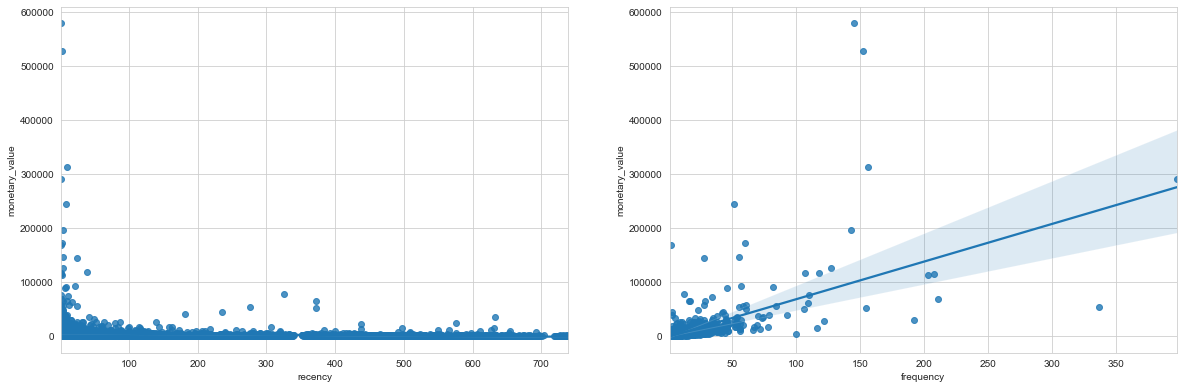

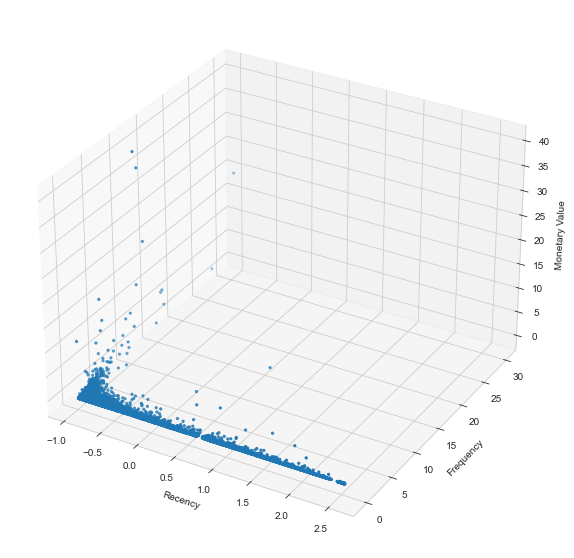

In [19]:
# 3D plot standardized data

fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary_value', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary_value', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = customer_data_scaled.recency
ys = customer_data_scaled.frequency
zs = customer_data_scaled.monetary_value
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.show()

In [20]:
# log scaling data

customer_history_df_log = customer_history_df.copy()

customer_history_df_log['recency'] += 1.0
customer_history_df_log['frequency'] += 1.0
customer_history_df_log['monetary_value'] += 1.0

customer_history_df_log['recency'] = np.log(customer_history_df_log['recency'])
customer_history_df_log['frequency'] = np.log(customer_history_df_log['frequency'])
customer_history_df_log['monetary_value'] = np.log(customer_history_df_log['monetary_value'])
# feature_vector = ['totalprice_log', 'recency_log','frequency_log']
feature_vector = ['recency', 'frequency', 'monetary_value']
X_subset_log = customer_history_df_log[feature_vector] #.as_matrix()
X_subset_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 0 to 5880
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         5881 non-null   float64
 1   frequency       5881 non-null   float64
 2   monetary_value  5881 non-null   float64
dtypes: float64(3)
memory usage: 183.8 KB


In [22]:
X_scaled_log = preprocessing.StandardScaler().fit_transform(X_subset_log)

In [23]:
# show log scaled data properties
pd.DataFrame(X_scaled_log, columns=X_subset_log.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
recency,5881.0,-1.285318e-16,1.000085,-2.411921,-0.742992,0.077063,0.954326,1.380009
frequency,5881.0,7.498395e-17,1.000085,-1.057568,-1.057568,-0.201224,0.655120,5.485112
monetary_value,5881.0,-3.418830e-16,1.000085,-4.889339,-0.700418,-0.035107,0.649148,4.634939


In [24]:
customer_data_scaled_log = pd.DataFrame(X_scaled_log, columns=X_subset_log.columns)
customer_data_scaled_log.head()

,recency,frequency,monetary_value
0,0.856321,1.254938,3.189908
1,-2.151924,0.800635,1.211356
2,-0.079383,0.299705,0.572318
3,-0.935429,0.074457,1.135655
4,0.824152,-1.057568,-0.716288


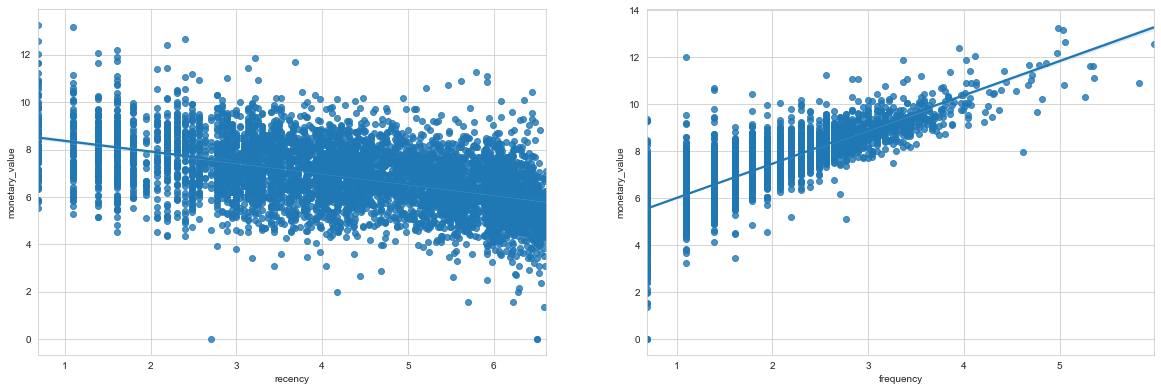

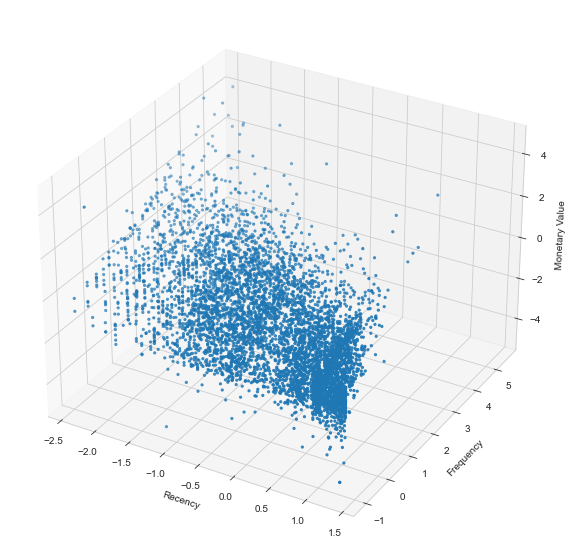

In [25]:
# 3D plot log scaled data

fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary_value', data=customer_history_df_log)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary_value', data=customer_history_df_log)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = customer_data_scaled_log.recency
ys = customer_data_scaled_log.frequency
zs = customer_data_scaled_log.monetary_value
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.show()

## Save dataset on file

In [ ]:
customer_data_scaled_log.to_csv(path_or_buf="../dataset/Online_Retail_II/customer_data_log_scaled.csv", 
                                encoding = 'ISO-8859-1', 
                                index = False)

In [29]:
customer_data_scaled.to_csv(path_or_buf="../dataset/Online_Retail_II/customer_data.csv", 
                             encoding = 'ISO-8859-1', 
                             index = False)